In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import sys
import bisect

sys.path.insert(0, '..')

import keras.layers
from keras.layers import Input, Dense, LocallyConnected1D, Reshape
from keras.models import Model
from keras import regularizers
from sklearn import preprocessing

from IPython.display import SVG
from keras.utils import model_to_dot


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

Using TensorFlow backend.


In [2]:
import umap
import umap.plot

In [3]:
raw_df = pd.read_hdf("../data/processed/summaries_protoss.hdf", "summaries")
raw_df = raw_df[raw_df.game_duration > 280]
raw_df.head()

,game_start,game_duration,self_won,self_name,self_race_is_protoss,self_race_is_zerg,self_race_is_terran,opponent_name,opponent_race_is_protoss,opponent_race_is_zerg,...,TwilightCouncil_start,TwilightCouncil_weight,VoidRay_start,VoidRay_weight,WarpGate_start,WarpGate_weight,WarpPrism_start,WarpPrism_weight,Zealot_start,Zealot_weight
20d6247127ed58eeca069051672d3e8c3598e132d2fc6c445040701499b72acf_0,2020-02-01 15:07:59,675,1.0,ShoWTimE,1.0,0.0,0.0,Trap,1.0,0.0,...,1000.000000,0.000000,1000.0,0.0,13.038405,1.0,1000.0,0.0,1000.000000,0.0
20d6247127ed58eeca069051672d3e8c3598e132d2fc6c445040701499b72acf_1,2020-02-01 15:07:59,675,0.0,Trap,1.0,0.0,0.0,ShoWTimE,1.0,0.0,...,1000.000000,0.000000,1000.0,0.0,13.000000,1.0,1000.0,0.0,1000.000000,0.0
50cb3b2f33692227e2e50e0e4fab529a44c4bfe9bfd9e8137c08a81e94f08370_1,2020-02-02 12:13:08,886,0.0,ShoWTimE,1.0,0.0,0.0,cure,0.0,0.0,...,13.856406,1.000000,1000.0,0.0,13.114877,1.0,1000.0,0.0,13.266499,1.0
038ca41ecf0198facf7425bfd5cfa9237f144e4e41d9c556b204612d55088de1_1,2020-02-02 13:34:45,825,0.0,ShoWTimE,1.0,0.0,0.0,cure,0.0,0.0,...,14.764823,1.927659,1000.0,0.0,13.416408,1.0,1000.0,0.0,1000.000000,0.0
eaa36f7eff9c1682c86aace4ff319bce335f3d61c6e362432c504618e3a95055_0,2020-02-01 14:58:20,531,0.0,ShoWTimE,1.0,0.0,0.0,Trap,1.0,0.0,...,1000.000000,0.000000,1000.0,0.0,13.000000,1.0,1000.0,0.0,1000.000000,0.0


In [4]:
metadata_columns = """
self_won
game_start
game_duration
self_name self_race_is_protoss self_race_is_zerg self_race_is_terran
opponent_name
""".split()
weight_columns = [col for col in raw_df.columns if col.endswith("_weight")]

data_columns = [col for col in raw_df.columns if col not in metadata_columns and col not in weight_columns]

df = raw_df[data_columns]
min_max_scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df), columns=df.columns, index=df.index)

encoding_dim = 10

In [5]:
len(data_columns)


48

In [6]:
input_data = Input(shape=(len(df.columns),))

#encoded = Dense(20, activation='relu')(input_data)

encoded = Dense(encoding_dim, activation='relu')(input_data)

#decoded = Dense(20, activation='relu')(encoded)

decoded = Dense(len(df.columns), activation='sigmoid')(encoded)

autoencoder = Model(input_data, decoded)


In [7]:
encoder = Model(input_data, encoded)


1018


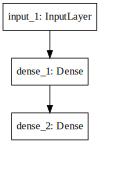

In [8]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')
print(autoencoder.count_params())
SVG(model_to_dot(autoencoder).create(prog='dot', format='svg'))


In [9]:
x_all = df.sample(frac=1.0).values
num_samples = int(0.95 * x_all.shape[0])
x_train, x_test = x_all[:num_samples, :], x_all[num_samples:, :]
print("Training on {} samples. Testing on {}.".format(
    num_samples, x_all.shape[0] - num_samples))


Training on 2855 samples. Testing on 151.


In [10]:
history = autoencoder.fit(x_train, x_train,
                epochs=2000,
                batch_size=1024,
                shuffle=True,
                verbose=0,
                validation_data=(x_test, x_test))


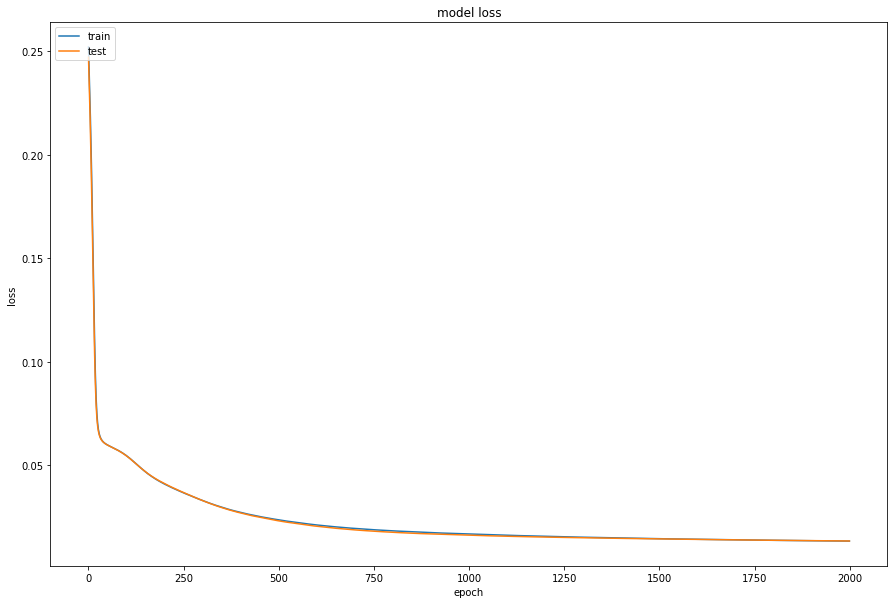

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
cluster_games_df = raw_df[raw_df.game_start > datetime.datetime(2020, 1, 1)]
original_space = min_max_scaler.transform(cluster_games_df[data_columns].values)
encoded_space =autoencoder.predict(original_space)

In [13]:
encoded_space[0]

array([9.85806286e-01, 2.09836056e-03, 4.26635612e-03, 8.84517014e-01,
       9.85775769e-01, 9.98453379e-01, 4.76666290e-04, 9.99896526e-01,
       1.03822397e-03, 9.99771059e-01, 1.68004321e-04, 2.52428494e-04,
       9.95341063e-01, 2.40943191e-04, 2.30233371e-03, 7.34462883e-05,
       1.47962419e-04, 9.98849988e-01, 9.96794522e-01, 1.03950515e-01,
       1.84455377e-04, 1.60291587e-04, 9.99631405e-01, 3.45958106e-04,
       8.88589680e-01, 3.47170193e-04, 6.57226294e-02, 9.74681497e-01,
       9.99870062e-01, 3.36026686e-04, 9.99999642e-01, 9.95806456e-01,
       3.63666117e-02, 1.10188033e-03, 4.69915658e-01, 9.98836577e-01,
       8.87278914e-02, 4.42923792e-03, 8.40798497e-01, 1.04156811e-06,
       9.98467743e-01, 4.33250912e-04, 2.02741503e-04, 9.99950290e-01,
       9.99828696e-01, 3.60823399e-03, 8.59105825e-01, 9.62143958e-01],
      dtype=float32)

In [14]:
original_space[0]

array([1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 3.21960918e-03, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 6.27809621e-04,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 9.46047043e-02,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 6.68062498e-03, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 4.66553965e-01, 1.00000000e+00,
       2.58908561e-03, 1.17761492e-04, 1.00000000e+00, 1.96849265e-04,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 4.34361690e-04, 1.00000000e+00, 1.00000000e+00])

In [15]:
diffs = encoded_space - original_space
cluster_games_df['creativity'] = np.einsum("ij,ij->i", diffs, diffs)

<ipython-input-15-e9fec5a3d2b9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_games_df['creativity'] = np.einsum("ij,ij->i", diffs, diffs)


In [16]:
creative_games_df= cluster_games_df.sort_values('creativity')
creative_games_won = creative_games_df[creative_games_df['self_won'] > 0]
creative_games_won.tail(20)

,game_start,game_duration,self_won,self_name,self_race_is_protoss,self_race_is_zerg,self_race_is_terran,opponent_name,opponent_race_is_protoss,opponent_race_is_zerg,...,TwilightCouncil_weight,VoidRay_start,VoidRay_weight,WarpGate_start,WarpGate_weight,WarpPrism_start,WarpPrism_weight,Zealot_start,Zealot_weight,creativity
6f503542f817cd8d27ba0891e78ae8978e933cbce6e88e108ddf5d167308d69c_1,2020-01-12 05:58:43,547,1.0,<trap11>llllllllllll,1.0,0.0,0.0,<AFSC2>DRG,0.0,1.0,...,0.0,1000.0,0.0,1000.000000,0.0,1000.000000,0.000000,1000.000000,0.000000,2.188996
0797c5589100d358f5b3fb759253daf561b5966d940817f23737e38c99f8a7c5_0,2020-02-24 17:51:34,379,1.0,Has,1.0,0.0,0.0,TLO,0.0,1.0,...,0.0,1000.0,0.0,1000.000000,0.0,1000.000000,0.000000,1000.000000,0.000000,2.224939
c6bff1a4b46a5dd831e6eb3b6c77e827e09f3848914f55146fa0559c1b4bd433_0,2020-01-04 17:25:52,794,1.0,<сSсǃ>SKillous,1.0,0.0,0.0,<KOVA>Mixu,0.0,1.0,...,0.0,1000.0,0.0,1000.000000,0.0,1000.000000,0.000000,1000.000000,0.000000,2.263060
0a4a75c2cad737522f4b913901e360b83557be89f2aa874f56b0d8c58fefecae_0,2020-02-29 17:24:29,618,1.0,Dear,1.0,0.0,0.0,Zest,1.0,0.0,...,0.0,1000.0,0.0,13.453624,1.0,1000.000000,0.000000,1000.000000,0.000000,2.427963
be52e7b7c084e359b8f9a0b46b8fafbb942b53659a39f3acd66fc5a23bb9b226_0,2020-02-27 11:00:08,570,1.0,Dear,1.0,0.0,0.0,Has,1.0,0.0,...,0.0,1000.0,0.0,13.228757,1.0,1000.000000,0.000000,1000.000000,0.000000,2.428766
99c033c792d942a6ff4b38db2d7df1a15c38f9d038848cf426bfa359758751cc_1,2020-02-27 12:10:02,345,1.0,Has,1.0,0.0,0.0,Stats,1.0,0.0,...,0.0,1000.0,0.0,12.884099,1.0,1000.000000,0.000000,1000.000000,0.000000,2.648895
03d8e90984495e6f687a5d186d88f48332478557ad712dc8a7ab29d113b6dcc9_0,2020-03-30 17:59:00,692,1.0,<Blacer>Geralt,1.0,0.0,0.0,ShoWTimE,1.0,0.0,...,0.0,1000.0,0.0,13.228757,1.0,1000.000000,0.000000,13.076697,1.000000,2.752398
37793def87056f1b4ce68c20886237e3ea48e8704eaad98468c704d3cfacd6a8_0,2020-03-30 13:04:23,490,1.0,IIIIIIIIIIII,1.0,0.0,0.0,starry,0.0,1.0,...,0.0,1000.0,0.0,13.638182,1.0,1000.000000,0.000000,11.916375,2.826450,2.835710
d110b4487fd64271c9b309b2c13eb4f12e00b5f5da9afe1c11f2a08d6f30f83b_1,2020-03-31 13:55:55,369,1.0,<BSGSC2>Hurricane,1.0,0.0,0.0,<DLG>SortOf,0.0,1.0,...,0.0,1000.0,0.0,13.964240,1.0,1000.000000,0.000000,11.747340,1.840896,2.856059
7e24ba821ba1bb8e7904a7aa9351b075baea931027ba9d5949570d1612337ee9_1,2020-01-17 11:16:40,420,1.0,<АDV>Licemer,1.0,0.0,0.0,<Wardi>Wardí,0.0,1.0,...,0.0,1000.0,0.0,13.856406,1.0,1000.000000,0.000000,10.954451,1.821690,3.014998


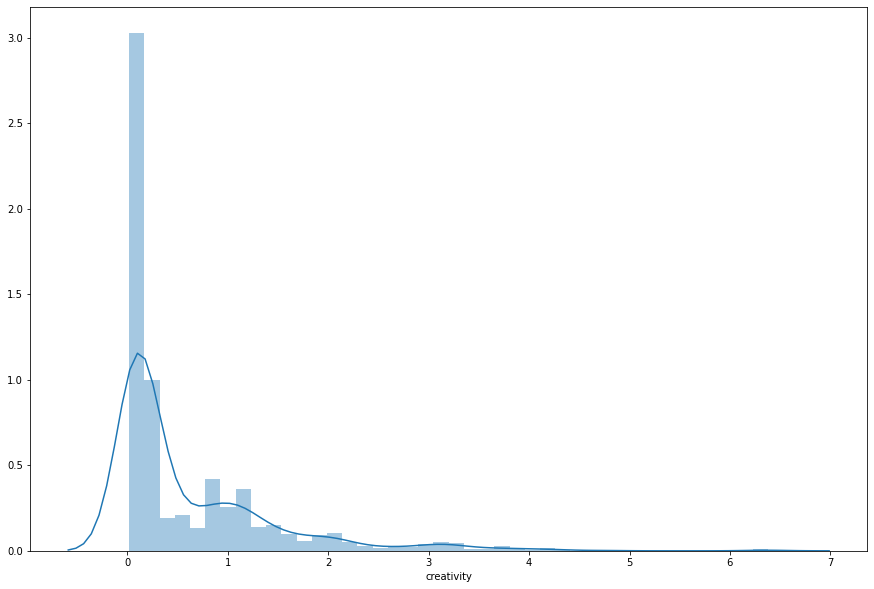

In [17]:
sns.distplot(cluster_games_df.creativity)

In [26]:
def summarize_player(*names):
    names = [n.lower() for n in names]
    series = cluster_games_df[cluster_games_df.self_name.str.lower().isin(names)].creativity
    print(series.describe())
    return sns.distplot(series, bins=15)

def summarize_player_contains(name):
    all_names = set(creative_games_df[creative_games_df['self_name'].str.lower().str.contains(name.lower())].self_name)
    print("Names to use: {}".format(sorted(all_names)))
    return summarize_player(*all_names)

Names to use: ['<Mkers>MaxPax', '<QTcIub>MaxPax', 'MaxPax']
count    21.000000
mean      1.842027
std       1.434631
min       0.071806
25%       0.640315
50%       1.848286
75%       2.586937
max       4.740919
Name: creativity, dtype: float64


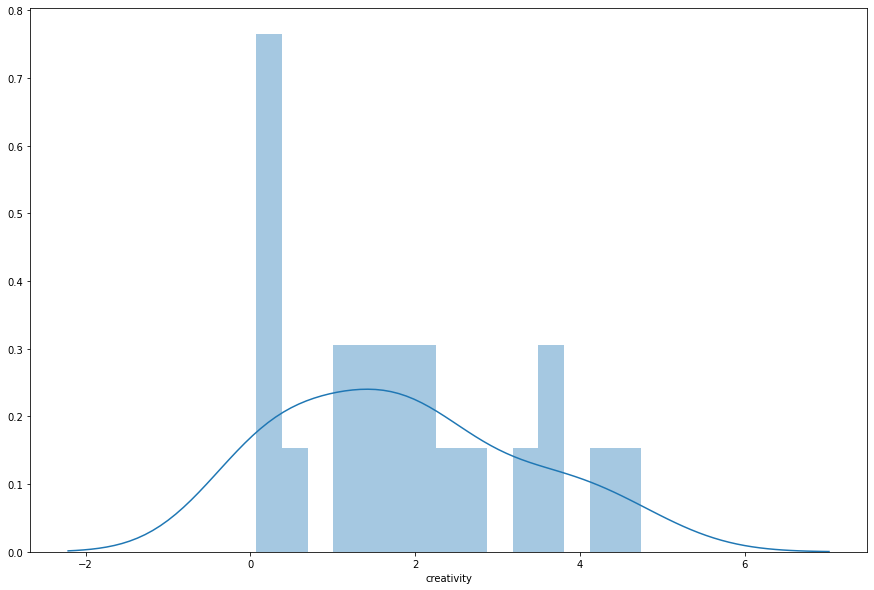

In [27]:
summarize_player_contains("maxpax")

Names to use: ['Dear']
count    59.000000
mean      0.401015
std       0.551991
min       0.017068
25%       0.075937
50%       0.109673
75%       0.578445
max       2.428766
Name: creativity, dtype: float64


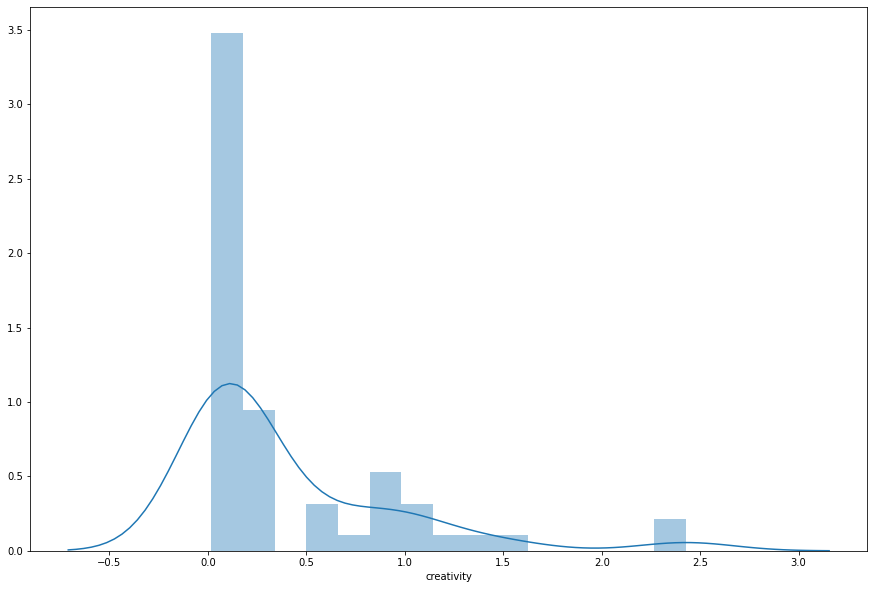

In [28]:
summarize_player_contains("dear")

Names to use: ['<QLASH>RotterdaM']
count    5.000000
mean     1.434768
std      1.794393
min      0.199838
25%      0.284784
50%      0.316733
75%      2.035912
max      4.336575
Name: creativity, dtype: float64


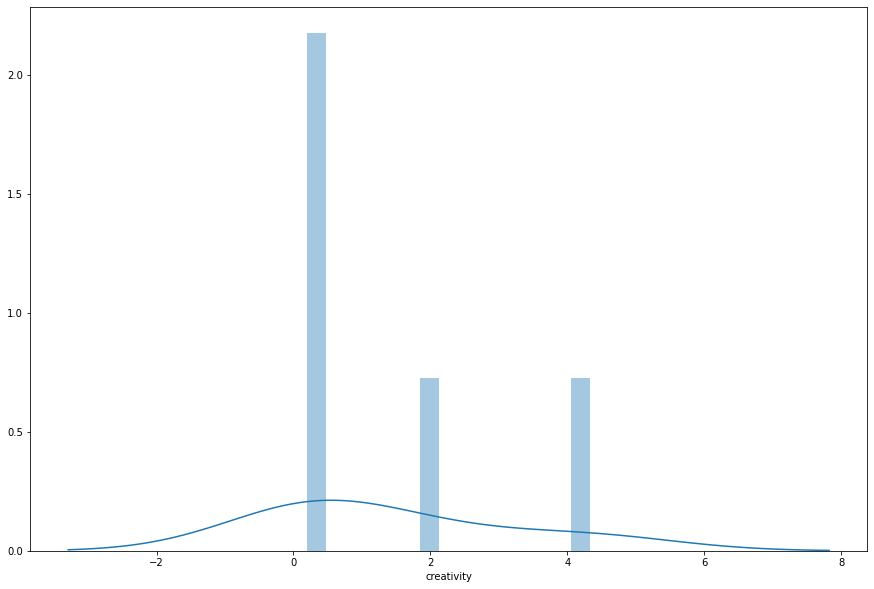

In [29]:
summarize_player_contains("rotterdam")

Names to use: ['<RYE>Zest', 'Zest']
count    106.000000
mean       0.509228
std        0.611937
min        0.017082
25%        0.082750
50%        0.170799
75%        0.855137
max        3.098125
Name: creativity, dtype: float64


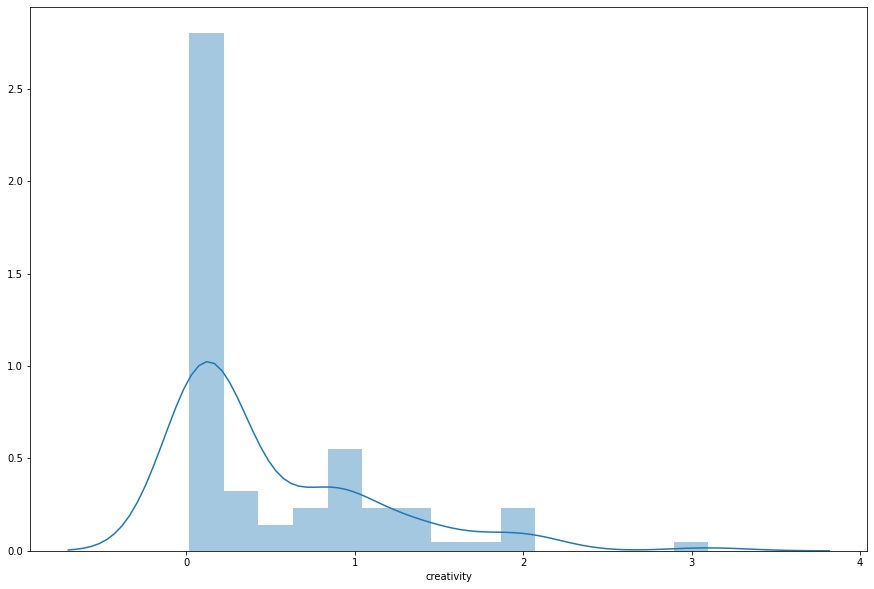

In [30]:
summarize_player_contains("zest")

Names to use: ['<cScNA>SKillous', '<сSсǃ>SKillous', 'SKillous']
count    51.000000
mean      0.839212
std       1.213842
min       0.016706
25%       0.096184
50%       0.318350
75%       1.157023
max       6.382017
Name: creativity, dtype: float64


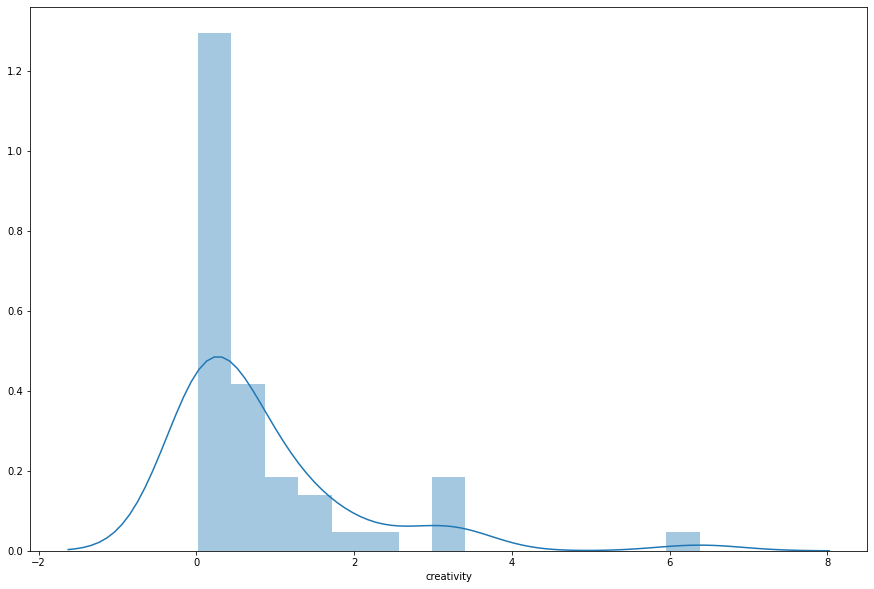

In [31]:
summarize_player_contains("skillous")